In [137]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from tqdm import tqdm
from scipy.stats import ortho_group

from netrep.metrics import GPStochasticMetric, GaussianStochasticMetric

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
def plot_line(estimated,true,variable,constant):
    plt.figure()
    
    plt.plot(variable[list(variable.keys())[0]], [e['dssd'] for e in estimated], 'o', label="dSSD")
    plt.plot(variable[list(variable.keys())[0]], [e['assd'] for e in estimated], 'o', label="aSSD")
    
    plt.plot(variable[list(variable.keys())[0]], [t['dssd'] for t in true], '--', c='tab:blue')
    plt.plot(variable[list(variable.keys())[0]], [t['assd'] for t in true], '--', c='tab:orange')
    
    plt.xlabel(list(variable.keys())[0])
    plt.ylabel("Distance")
    plt.title(
        "Varying "+ list(variable.keys())[0]+" - "+\
        "Constant "+ list(constant.keys())[0]+\
        " = "+ str(constant[list(constant.keys())[0]])
    )
    plt.legend()

## Define metrics

# Example two step process with analytical distances

### Define processes

In [141]:
# Constants
n_dims = 1
T = 2

# Define the two processes in terms of mean and cov
process_1 = lambda gamma, epsilon: (np.zeros(T), epsilon**2 * np.array([[1, gamma], [gamma, gamma**2]]))
process_2 = lambda gamma, epsilon: (np.zeros(T), epsilon**2 * np.array([[0, 0], [0, gamma**2]]))

# Analytical distances
true_dist = lambda gamma, epsilon: {'dssd': epsilon, 'assd': np.multiply(epsilon, np.sqrt(2 * np.square(gamma) + 1))}

# Metrics
metrics = {
    'dssd': GPStochasticMetric(n_dims=1, group="orth", type="non-adapted"),
    'assd': GPStochasticMetric(n_dims=1, group="orth", type="adapted")   
}

## Test shape metric implementations

### Stochastic metrics

In [142]:
# Example test, comparing analytical against estimated
gamma = 0.2
epsilon = 0.3

A,B = process_1(gamma, epsilon), process_2(gamma, epsilon)

estimated = {k:metrics[k].fit_score(A,B) for k in metrics.keys()}
true = true_dist(gamma,epsilon)

print('Estimated: ', estimated)
print('True: ', true)

Estimated:  {'dssd': 0.3, 'assd': 0.3117691451831648}
True:  {'dssd': 0.3, 'assd': 0.3117691453623979}


100%|██████████| 12/12 [00:00<00:00, 498.34it/s]

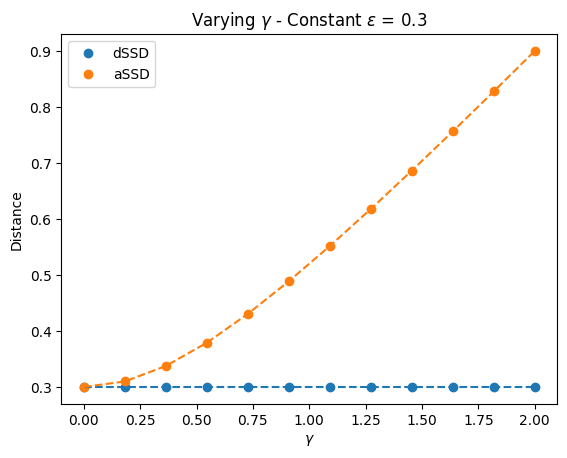

In [143]:
# Compute over gamma given epsilon
epsilon = 0.3
gammas = np.linspace(0.0,2.0,12)

estimated, true = [], []
for gamma in tqdm(gammas):
    A, B = process_1(gamma, epsilon), process_2(gamma, epsilon)
    estimated.append(
        {k:metrics[k].fit_score(A,B) for k in metrics.keys()}
    )
    true.append(
        true_dist(gamma,epsilon)
    )

plot_line(estimated,true,{'$\gamma$': gammas}, {'$\epsilon$': epsilon})


100%|██████████| 12/12 [00:00<00:00, 521.49it/s]


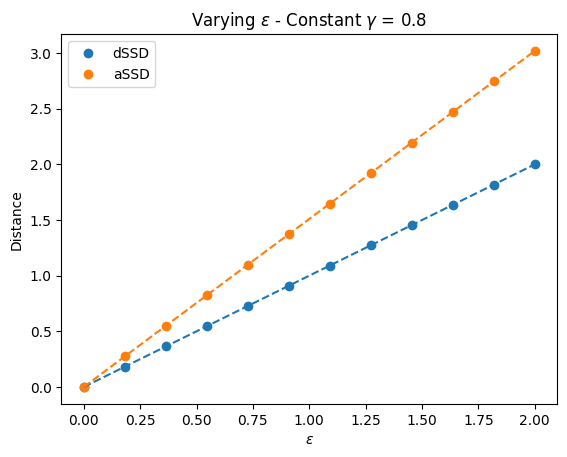

In [133]:
# Compute over epsilons given gamma
gamma = 0.8
epsilons = np.linspace(0.0,2.0,12)

estimated, true = [], []
for epsilon in tqdm(epsilons):
    A, B = process_1(gamma, epsilon), process_2(gamma, epsilon)
    estimated.append(
        {k:metrics[k].fit_score(A,B) for k in metrics.keys()}
    )
    true.append(
        true_dist(gamma,epsilon)
    )
    

plot_line(estimated,true,{'$\epsilon$': epsilons},{'$\gamma$': gamma})


100%|██████████| 12/12 [00:00<00:00, 518.90it/s]


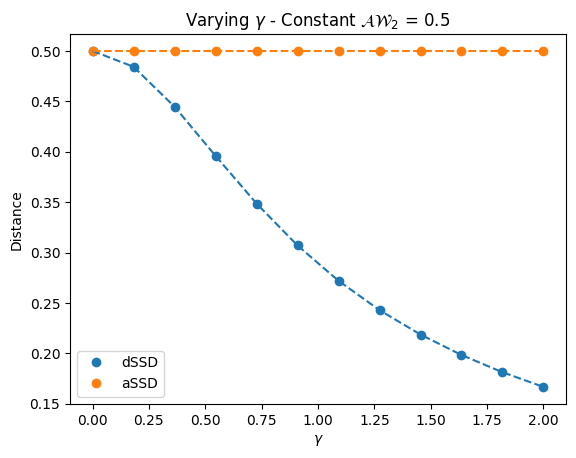

In [134]:
# Vary gamma and set epsilon such that AW is constant

desired_AW = 0.5

estimated, true = [], []
for gamma in tqdm(gammas):
    epsilon = desired_AW / np.sqrt(2 * np.square(gamma) + 1)
    A, B = process_1(gamma, epsilon), process_2(gamma, epsilon)
    estimated.append(
        {k:metrics[k].fit_score(A,B) for k in metrics.keys()}
    )
    true.append(
        true_dist(gamma,epsilon)
    )
    

plot_line(estimated,true,{'$\gamma$': gammas},{'$\mathcal{AW}_2$': desired_AW})

### Project and evaluate distance in higher dimensions

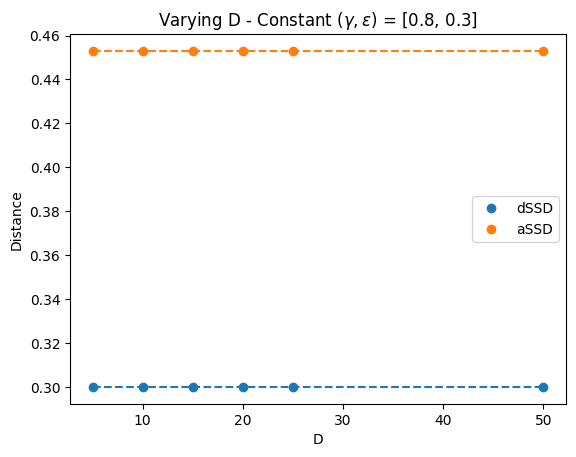

In [135]:
# Create orthogonal projection matrix

dims = [5,10,15,20,25,50]

gamma = .8
epsilon = .3

estimated, true = [], []
for i, obs_dims in enumerate(dims):
    # Metrics
    metrics = {
        'dssd': GPStochasticMetric(n_dims=obs_dims, group="orth", type="non-adapted"),
        'assd': GPStochasticMetric(n_dims=obs_dims, group="orth", type="adapted")   
    }

    A, B = process_1(gamma, epsilon), process_2(gamma, epsilon)
    
    CA = np.kron(np.eye(T),ortho_group.rvs(obs_dims)[:,:1])
    CB = np.kron(np.eye(T),ortho_group.rvs(obs_dims)[:,:1])

    A_p, B_p = (CA@A[0], CA@A[1]@CA.T), (CB@B[0], CB@B[1]@CB.T)
    
    estimated.append(
        {k:metrics[k].fit_score(
            A_p, B_p
        ) for k in metrics.keys()}
    )
    true.append(
        true_dist(gamma,epsilon)
    )

plot_line(estimated,true,{'D': dims},{'$(\gamma,\epsilon)$': [gamma,epsilon]})